# Data visualization and clustering (experimentation)

Using blog features for the clusteringand coloring the points accordingly given a criterion (views, session time, etc). Will use different embedding models for preprocessing as experimentation.

https://github.com/openai/openai-cookbook/blob/main/examples/Clustering.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import webbrowser

from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from ast import literal_eval

In [42]:
df1 = pd.read_csv('../data/processed/futurice/blogs_with_analytics.csv')
df2 = pd.read_csv('../data/processed/futurice/futurice_keywords_keyphrases.csv')

df = df1[['link', 'title']].merge(df2, on='title', how='left')

df = df.drop(columns=['title', 'date'])
df.to_csv('../data/processed/futurice/keywords-keyphrases-popularwords.csv', index=False)

In [2]:
df_features = pd.read_csv('../data/processed/futurice/ada_embedded.csv')
df_features

,link,teaser text,title
0,https://futurice.com/blog/designops-small-team...,"[-0.006673905998468399, -0.0076184566132724285...","[0.004207737743854523, 0.0013730884529650211, ..."
1,https://futurice.com/blog/european-accessibili...,"[6.168761319713667e-05, -0.03273925185203552, ...","[0.011761698871850967, -0.011412479914724827, ..."
2,https://futurice.com/blog/group-decision-makin...,"[-0.0012263016542419791, 0.00877977255731821, ...","[-0.019247598946094513, -0.004845085553824902,..."
3,https://futurice.com/blog/futustories-from-con...,"[0.016187680885195732, -0.031209181994199753, ...","[0.017870938405394554, -0.03323367238044739, 0..."
4,https://futurice.com/blog/car-companion-apps,"[0.01631859503686428, 0.01113915629684925, 0.0...","[0.007656510453671217, 0.007315007038414478, 0..."
...,...,...,...
507,https://futurice.com/blog/futurice-europes-bes...,"[-0.0038007197435945272, -0.003014186630025506...","[0.001226890948601067, -0.021829383447766304, ..."
508,https://futurice.com/blog/you-must-be-somewher...,"[0.02372124046087265, 0.007541052531450987, 0....","[-0.0045366548001766205, -0.003510543843731284..."
509,https://futurice.com/blog/decision-making-at-f...,"[-0.002502993680536747, -0.03133834898471832, ...","[0.010000096634030342, -0.033111587166786194, ..."
510,https://futurice.com/blog/designing-and-buildi...,"[0.00048368831630796194, -0.02295435592532158,...","[-0.006927511189132929, -0.0044516995549201965..."


In [ ]:
df_stats = pd.read_csv('../data/processed/futurice/blogs_with_analytics.csv')
df_stats = df_stats.drop(columns=['title', 'category', 'teaser text', 'headings', 'text', 'bullets', 'full text'])
df_stats['date'] = pd.to_datetime(df_stats['date'])
df_stats.sort_values(by='views', ascending=False)

In [ ]:
df = df_features.merge(df_stats, on='link', how='left')
df.dropna(inplace=True)
df[:3]

In [18]:
#feature_column = 'title'
feature_column = 'teaser text'

X = np.vstack(df[feature_column].apply(literal_eval).apply(np.array).values)

# Reducing the dimensionality to 2 dimensions (t-SNE, PCA)
def reduce(X):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
    X_tsne = tsne.fit_transform(X)

    return X_pca, X_tsne

X_pca, X_tsne = reduce(X)
X_pca.shape

(511, 2)

In [19]:
def plot(X_pca, X_tsne, stat_column):
    y = df[stat_column].values.reshape(-1, 1)

    q20 = np.percentile(y, 20)
    q40 = np.percentile(y, 40)
    q60 = np.percentile(y, 60)
    q80 = np.percentile(y, 80)

    colors = []
    for value in y:
        if value <= q20:
            colors.append('red')  # 0-20%
        elif value <= q40:
            colors.append('darkorange')  # 20-40%
        elif value <= q60:
            colors.append('gold')  # 40-60%
        elif value <= q80:
            colors.append('turquoise')  # 60-80%
        else:
            colors.append('green')  # 80-100%

    legend_elements = [Line2D([0], [0], marker='o', color='w', label='0-20%', markersize=8, markerfacecolor='red'),
                       Line2D([0], [0], marker='o', color='w', label='20-40%', markersize=8, markerfacecolor='darkorange'),
                       Line2D([0], [0], marker='o', color='w', label='40-60%', markersize=8, markerfacecolor='gold'),
                       Line2D([0], [0], marker='o', color='w', label='60-80%', markersize=8, markerfacecolor='turquoise'),
                       Line2D([0], [0], marker='o', color='w', label='80-100%', markersize=8, markerfacecolor='green')]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f'Ada embbeded {feature_column}')
    fig.legend(handles=legend_elements, loc='upper right', title=f'{stat_column} percentile')


    ax1.set_title('PCA')
    ax1.scatter(X_pca[:, 0], X_pca[:, 1], picker=True, c=colors, alpha=0.5)

    ax2.set_title('t-SNE')
    ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], picker=True, c=colors, alpha=0.5)

    plt.show()

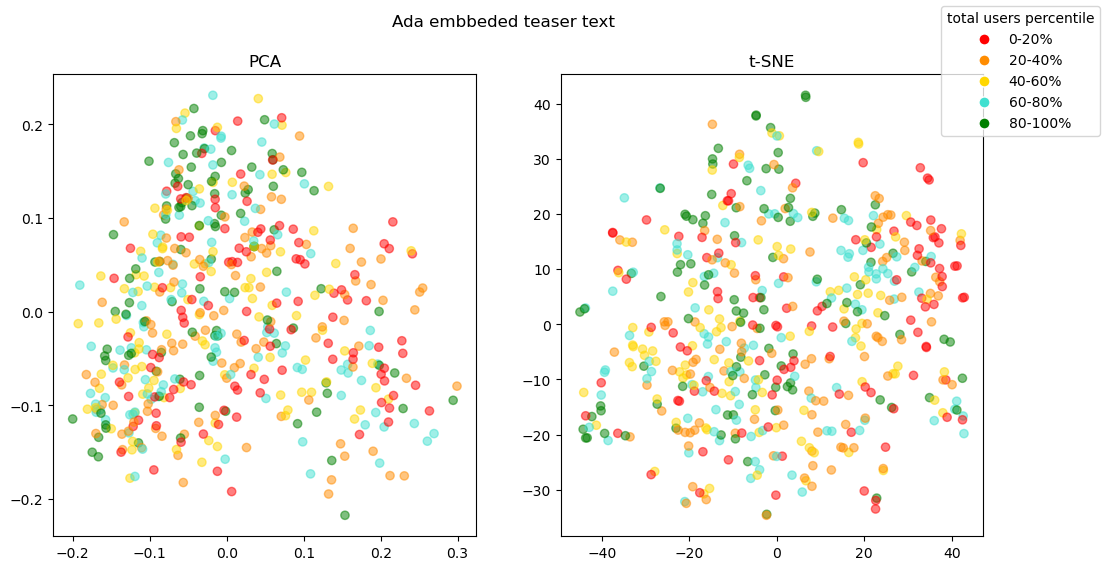

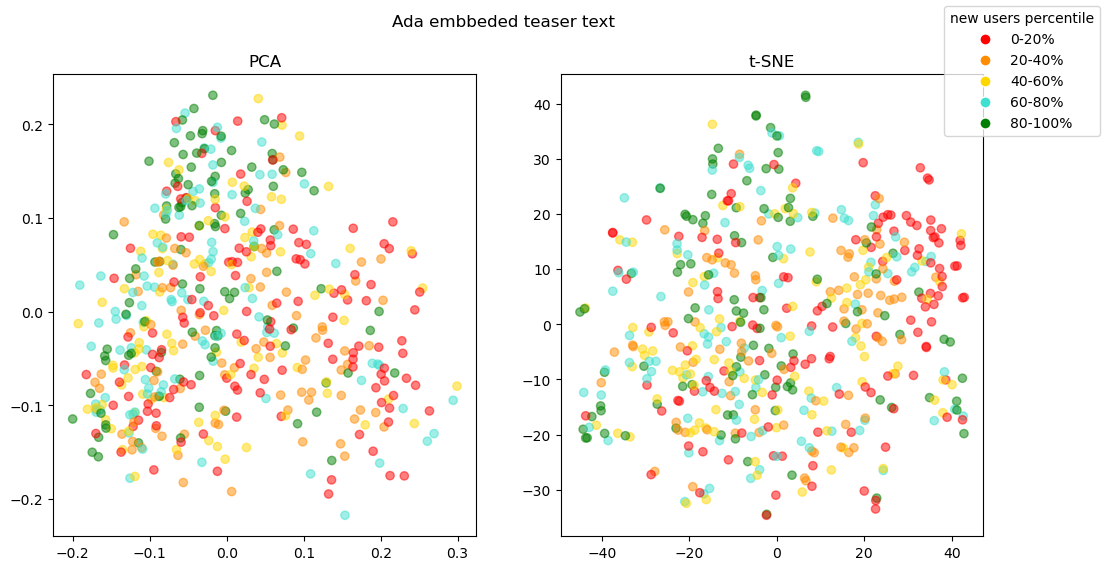

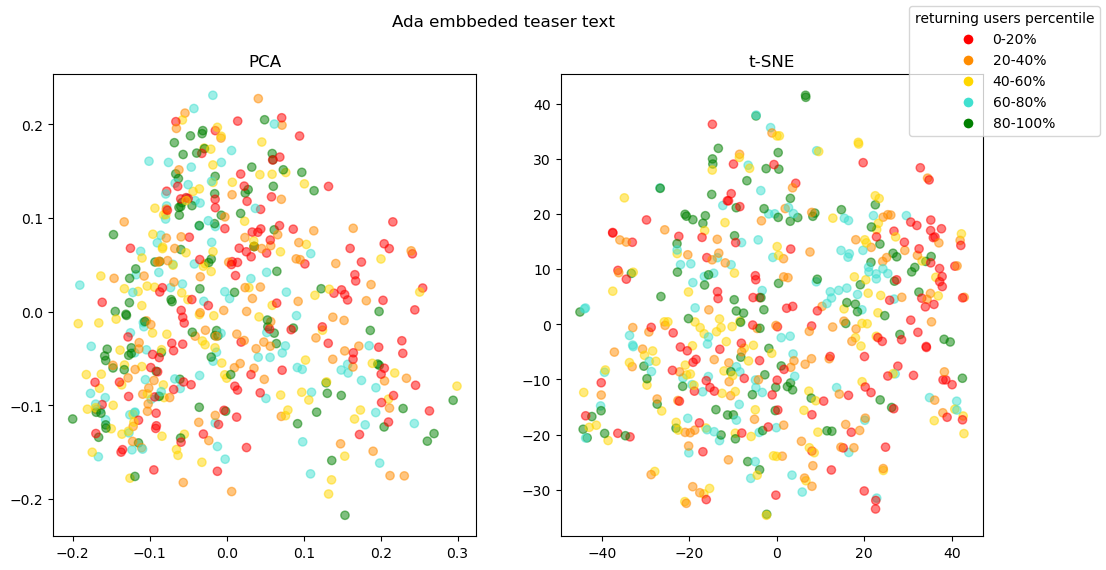

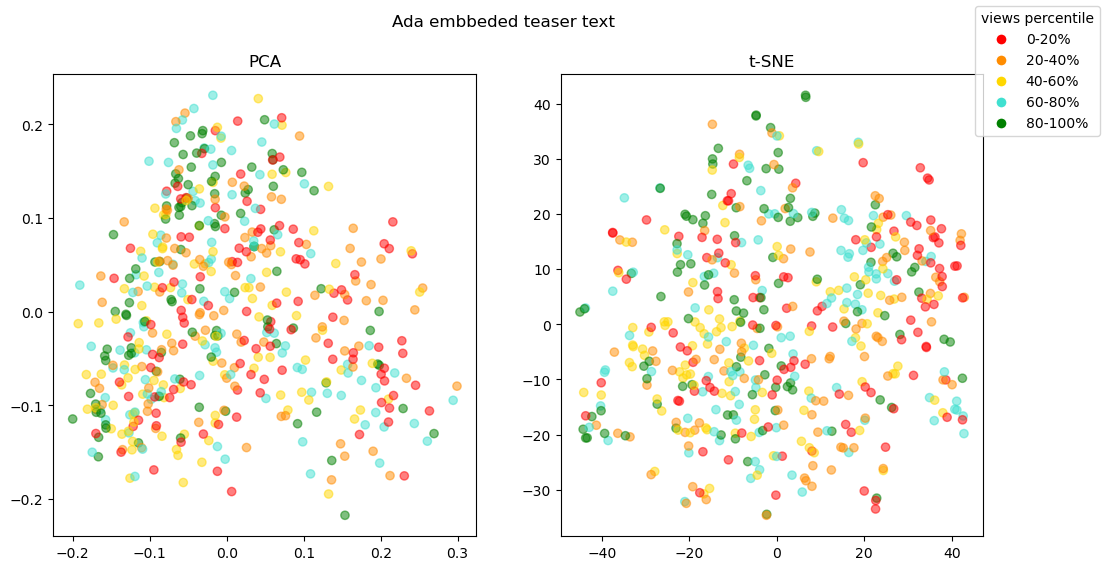

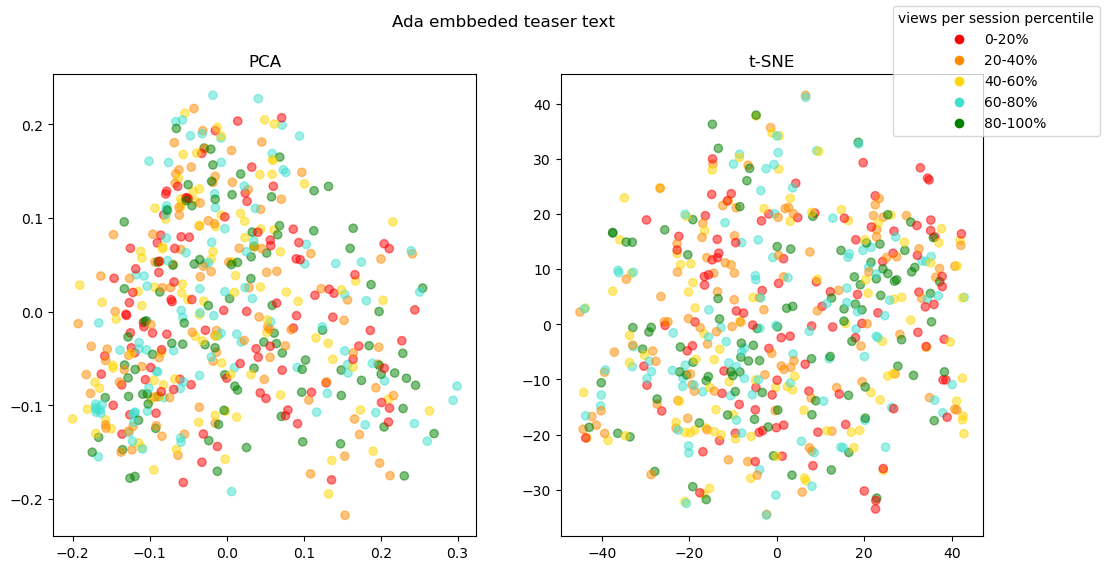

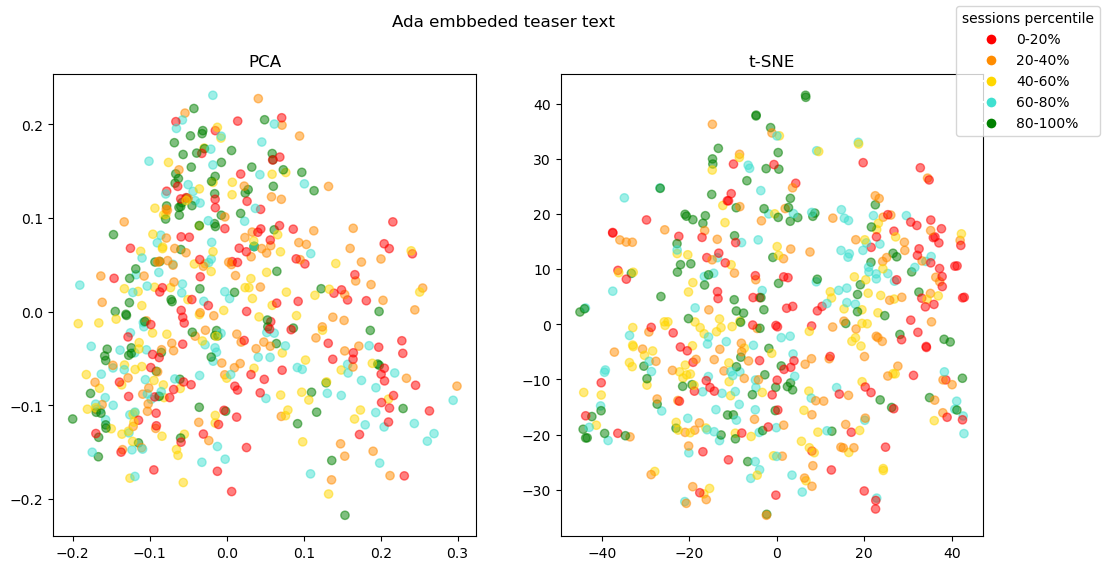

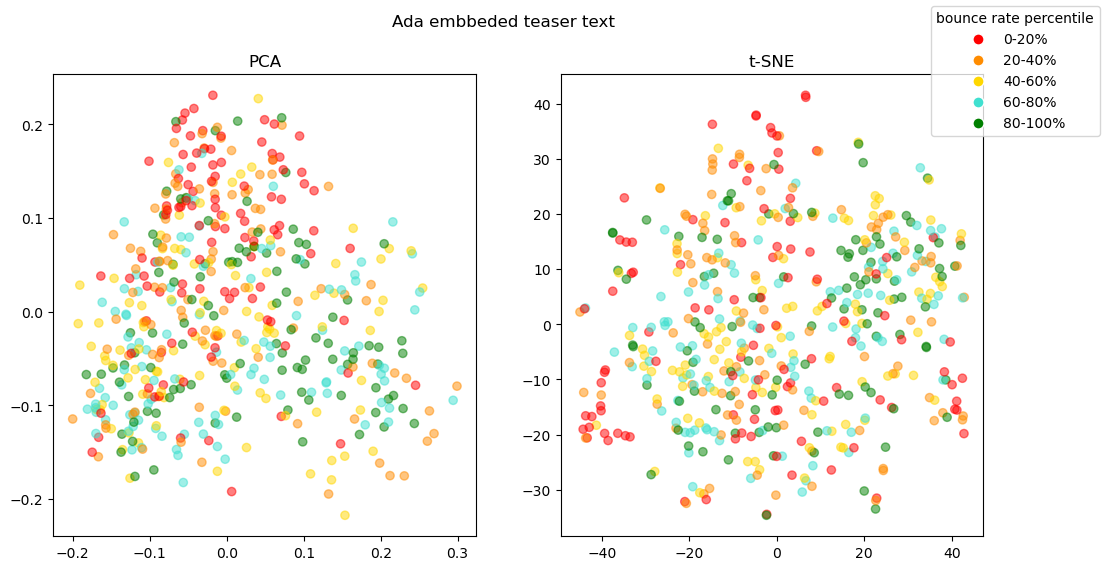

In [20]:
for stat_column in ['total users', 'new users', 'returning users', 'views', 'views per session', 'sessions', 'bounce rate']:
    plot(X_pca, X_tsne, stat_column)

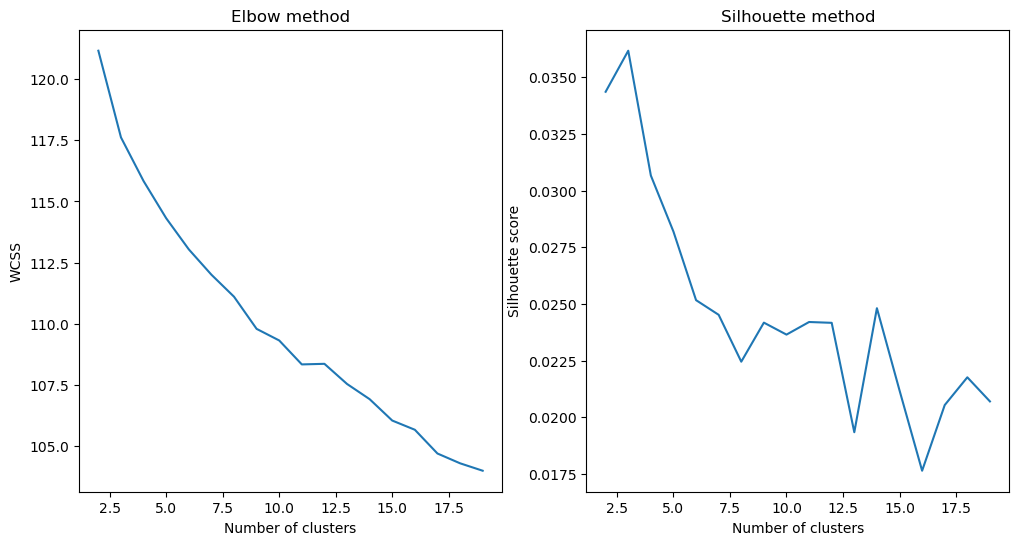

In [21]:
wcss = []
silhouette_scores = []

K = range(2, 20)

for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10).fit(X)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_, metric='euclidean'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(K, wcss)
ax1.set_title('Elbow method')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS')

ax2.plot(K, silhouette_scores)
ax2.set_title('Silhouette method')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette score')

plt.show()